In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

from scipy.stats import trim_mean

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [33]:
population_size = 45
num_faces = 32

# Useful Function

In [36]:
def extract_population_response(df, model_idx, col):
    """
    df: the dataframe to extract the responses from
    model_idx: which model we want
    col: the column index of responses we want

    The dataframe was made in the following format
                feat 1 | feat 2 | feat 3 ...
    ------------------------------------------
            |      
    model 0 |
            |
    ------------------------------------------
            |
    model 1 |
            |
    ...
    """
    series = df[col] #the 
    return series.iloc[model_idx*num_faces:(model_idx+1)*num_faces]

In [37]:
def create_mean_df(df, proportiontocut=0.2):
    new_df = pd.DataFrame(0, index=np.arange(population_size), columns=list(df.columns)+["model_idx"])

    for model_idx in range(population_size):
        for col_idx, col in enumerate(df.columns):
            series = extract_population_response(df, model_idx, col)
            ave_response = trim_mean(series, proportiontocut=proportiontocut)
            new_df.at[model_idx, col] = ave_response
            new_df.at[model_idx, 'model_idx'] = model_idx
    return new_df

In [38]:
def pairwise_anova(df, cols, dv, within, subject, correction, detailed):
    results = []
    
    for i in range(len(cols)-1):
        for j in range(i+1, len(cols)):
            temp = df[(df[within]==cols[i]) | (df[within]==cols[j])]
            
            res = pg.rm_anova(data=temp, dv=dv, within=within, subject=subject, 
                  correction=correction, detailed=detailed)

            results.append((cols[i], cols[j], res))
    return results

# Load Data

In [34]:
df_feature_combination = pd.read_csv("feature_combinations_june_14_activity_level.csv", index_col=0)

In [35]:
df_feature_combination.head()

,1 Eye,2 Eyes,"1 Eye, Nose","1 Eye, Mouth","2 Eyes, Nose","1 Eye, Nose, Mouth",Full Face,"2 Eyes, Mouth"
0,13.865,12.570,12.800,12.910,11.830,12.305,11.550,11.860
1,14.065,12.690,13.095,12.885,12.105,12.080,11.040,11.390
2,13.745,13.135,13.020,14.125,11.945,10.895,11.210,11.935
3,14.435,13.075,13.880,13.275,12.410,12.495,10.885,11.855
4,15.255,13.495,12.385,13.065,12.485,12.940,10.890,12.375


In [39]:
df_mean_responses = create_mean_df(df_feature_combination, proportiontocut=0)
df_mean_responses.head()

,1 Eye,2 Eyes,"1 Eye, Nose","1 Eye, Mouth","2 Eyes, Nose","1 Eye, Nose, Mouth",Full Face,"2 Eyes, Mouth",model_idx
0,14.647656,12.764375,13.475937,13.206406,11.862891,12.250547,10.902188,11.661016,0
1,14.856719,12.778672,13.723984,13.213437,11.930312,12.311641,10.861406,11.547500,1
2,15.385156,12.728984,14.185234,13.953672,11.908828,12.959844,11.053281,11.744141,2
3,16.644141,14.148516,15.292656,14.373672,13.169375,13.366484,11.756484,12.493125,3
4,15.116406,13.050937,13.933203,13.448047,12.176016,12.511875,11.096719,11.803203,4


## Histograms

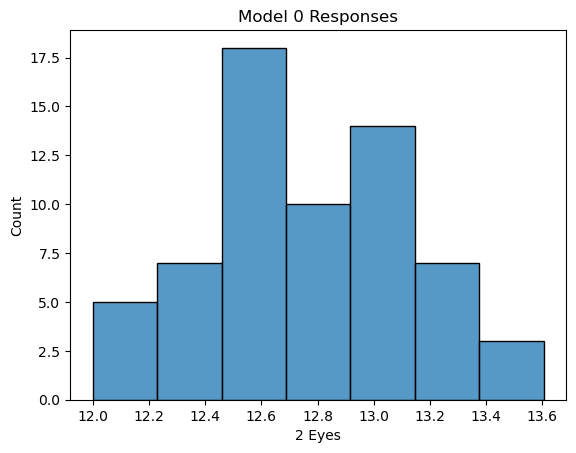

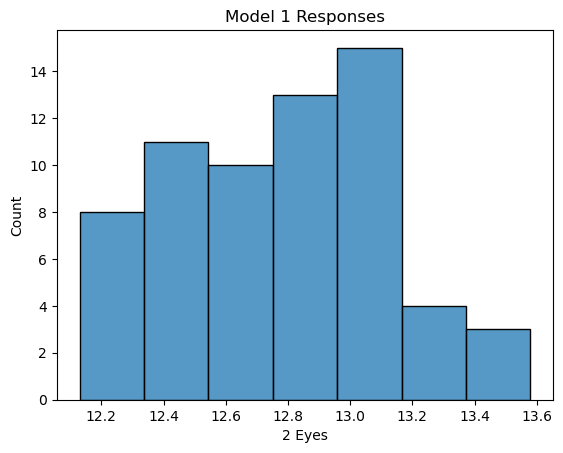

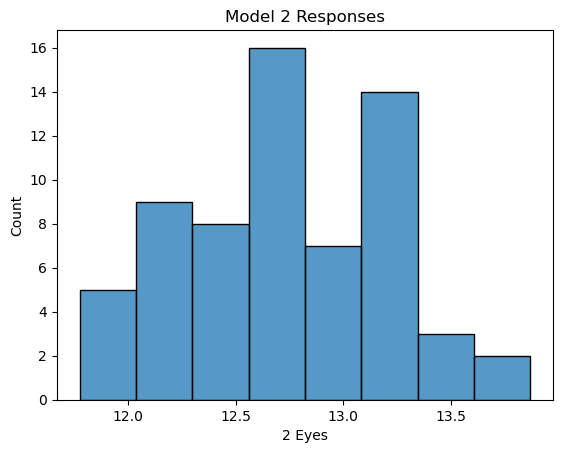

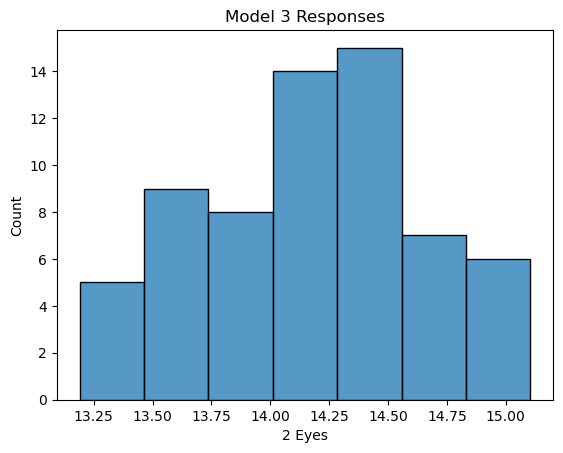

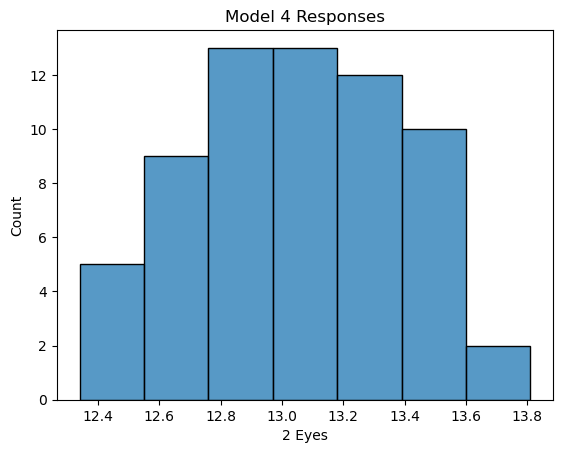

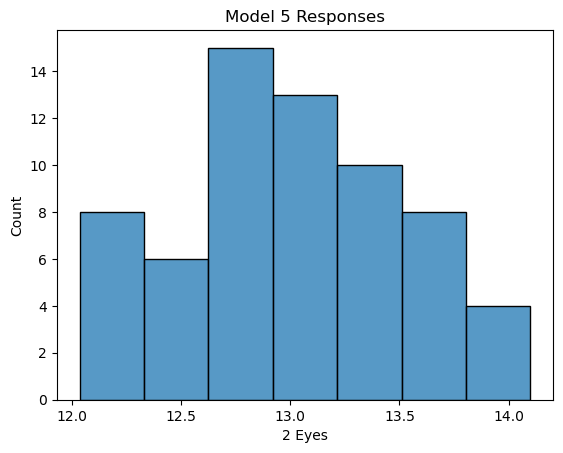

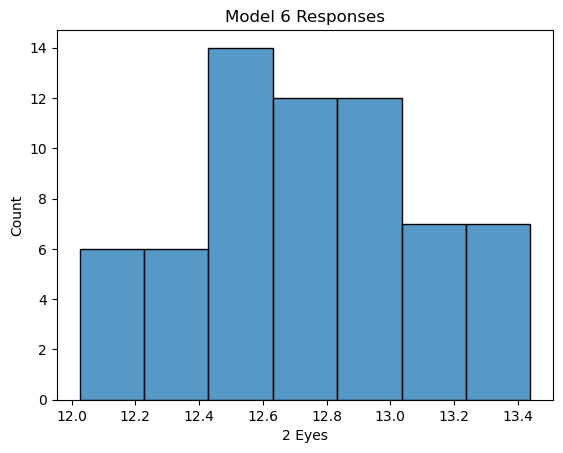

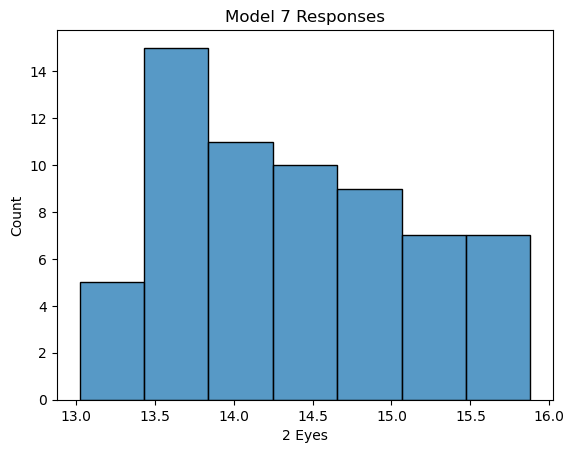

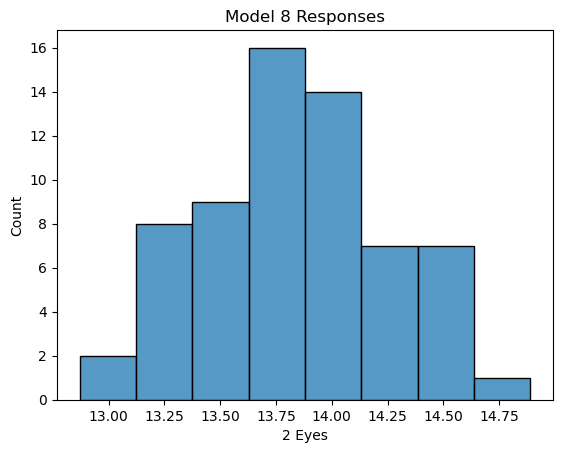

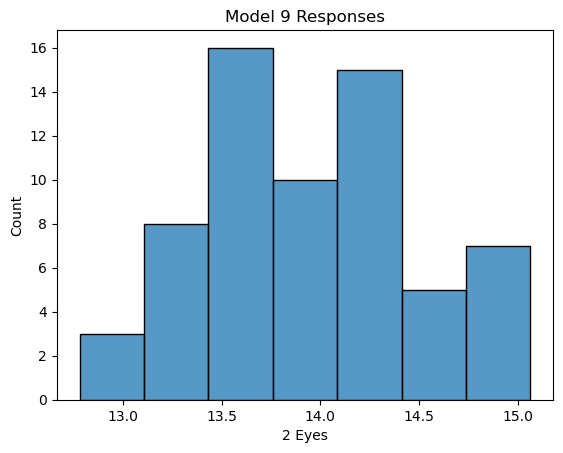

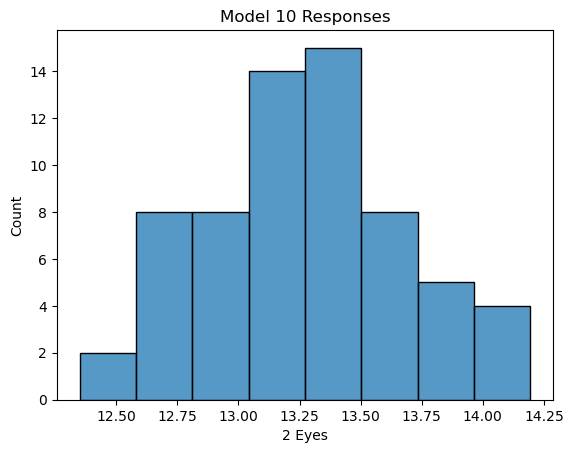

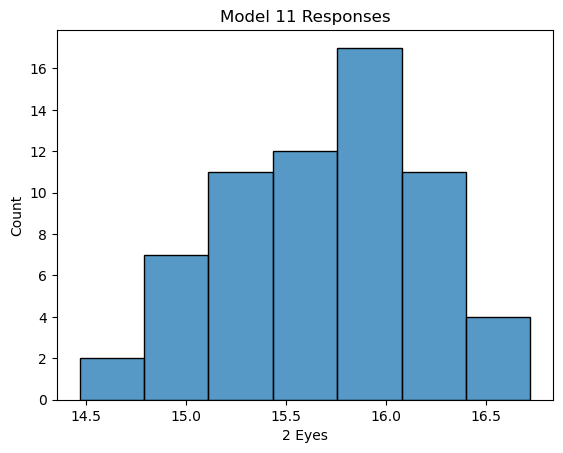

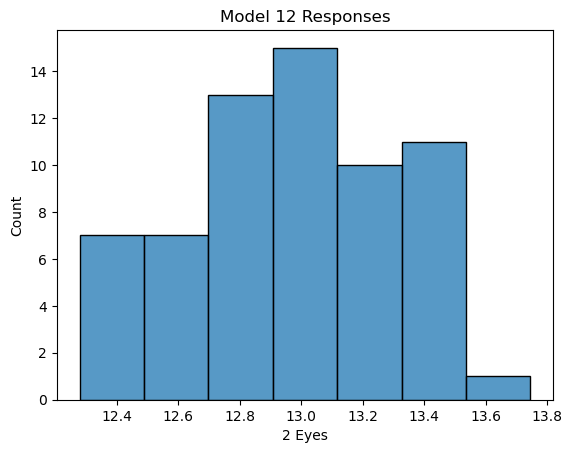

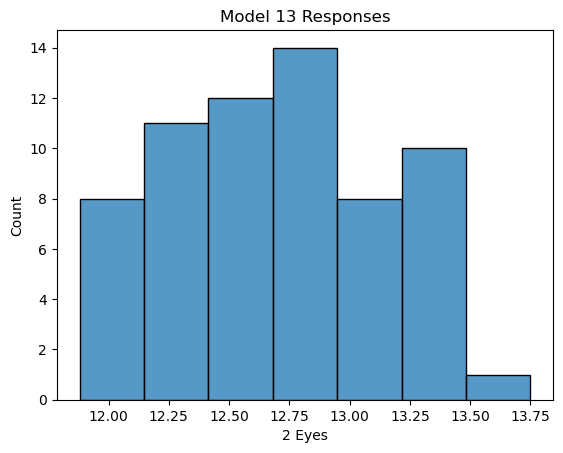

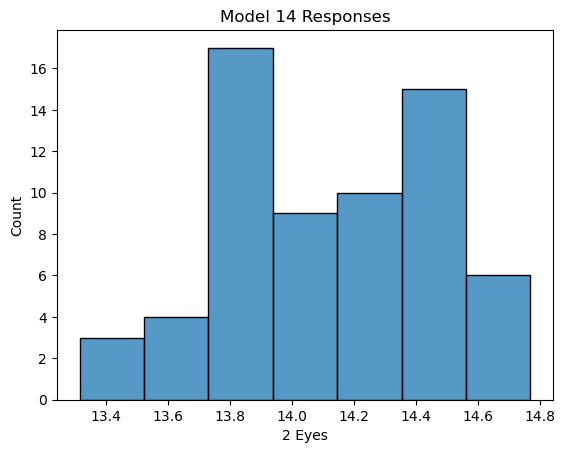

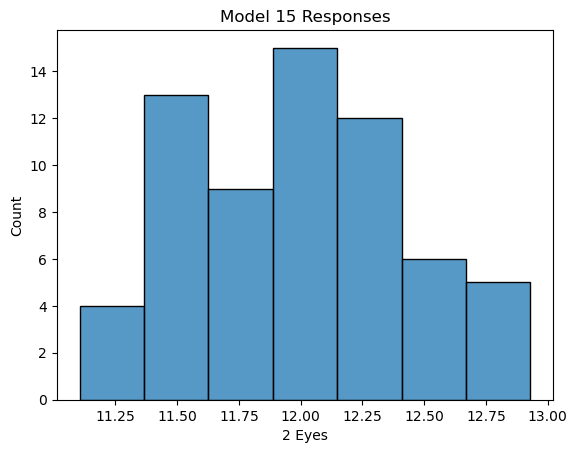

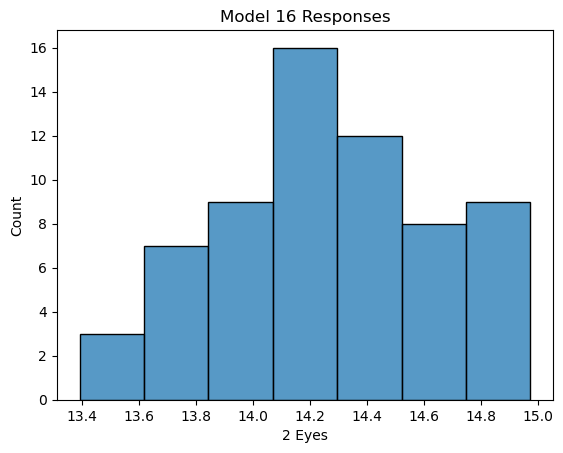

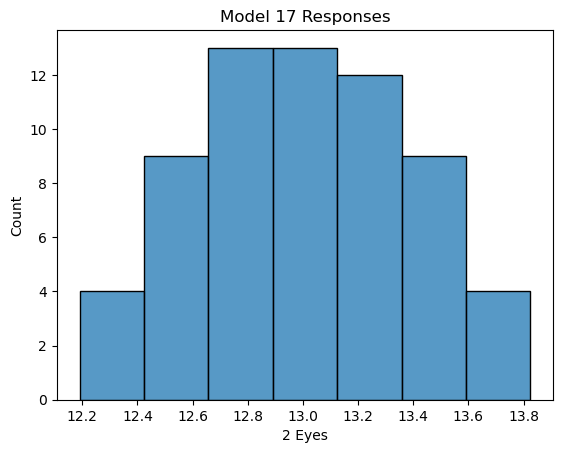

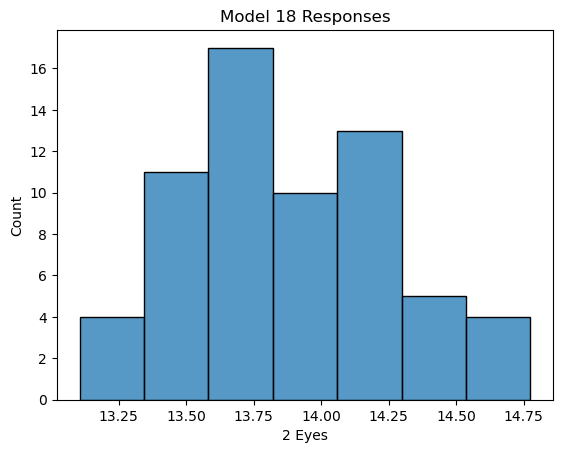

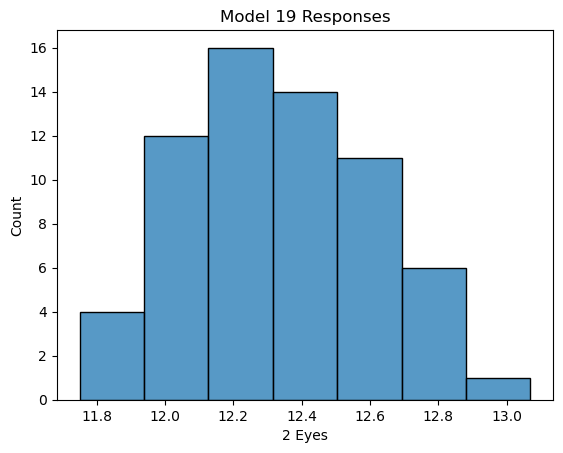

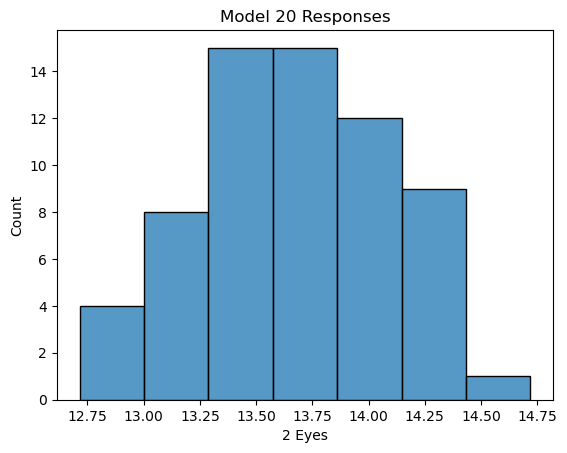

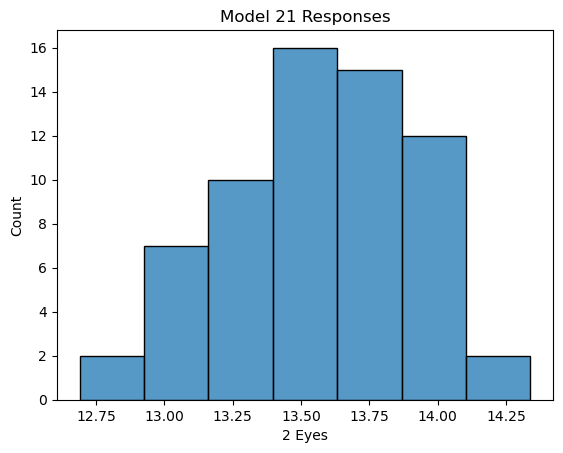

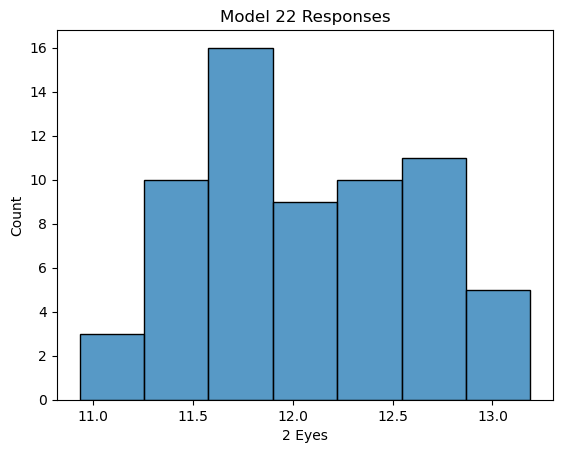

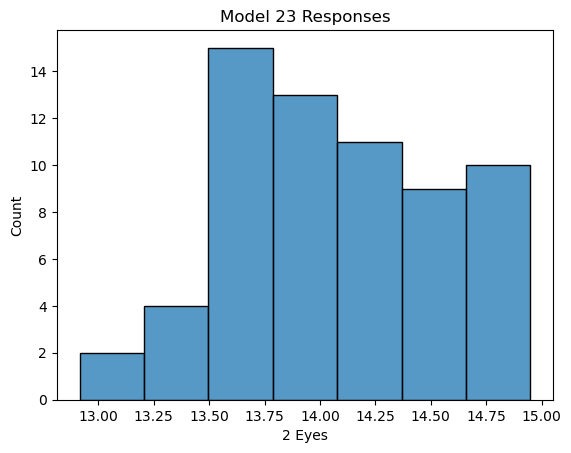

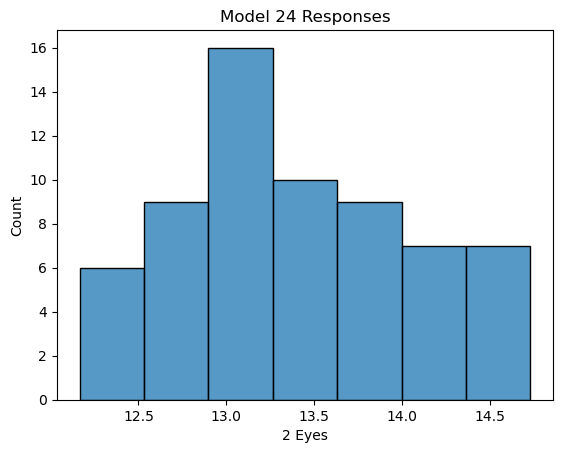

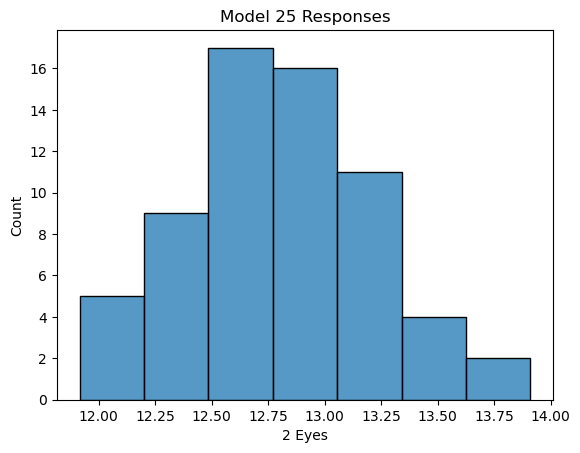

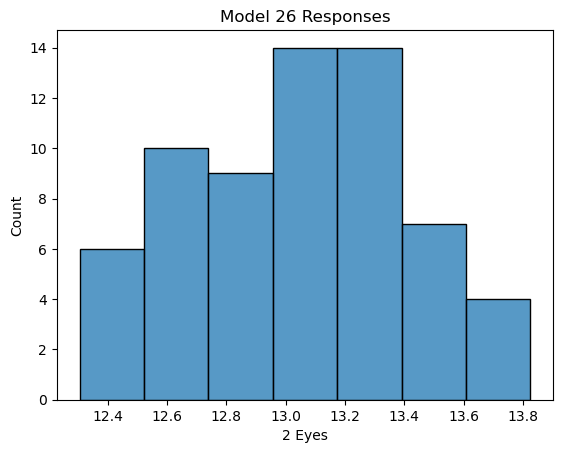

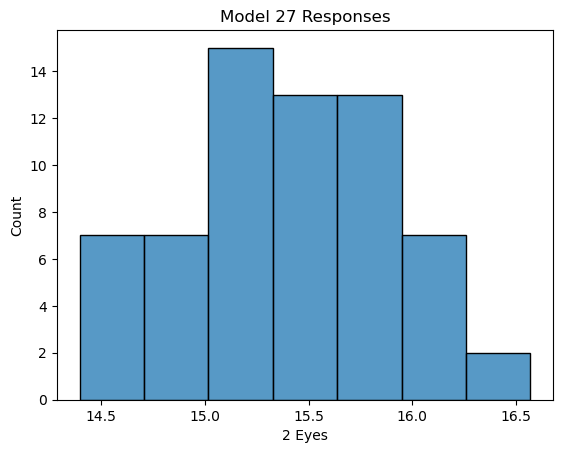

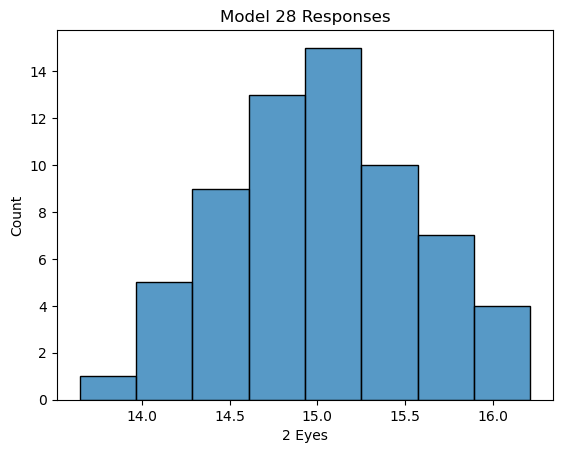

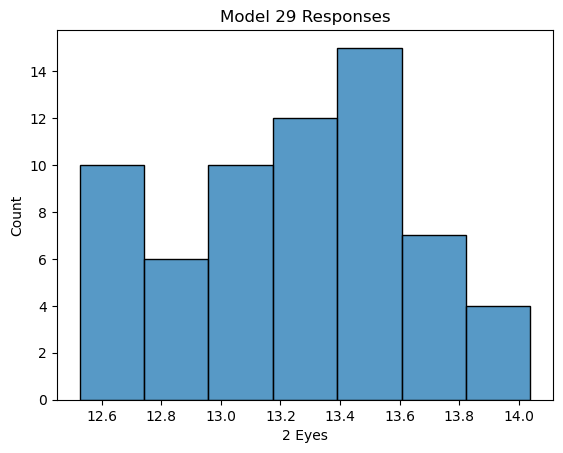

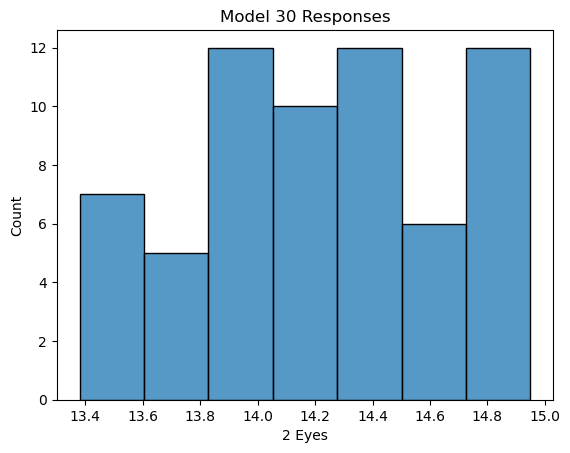

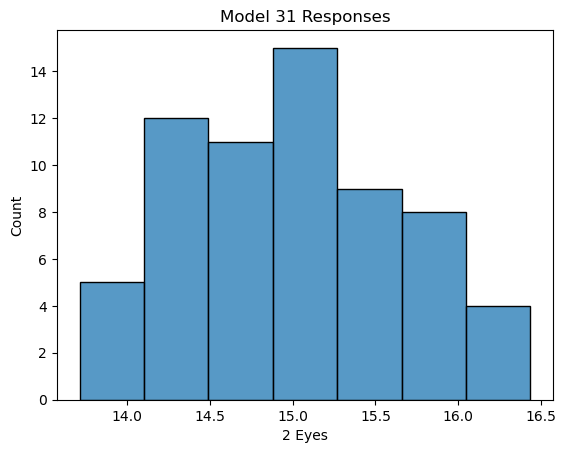

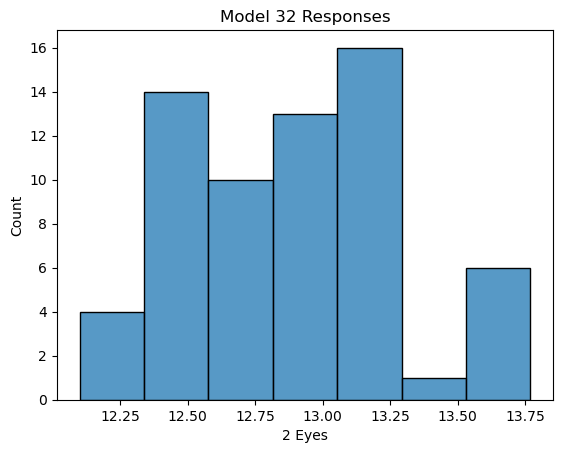

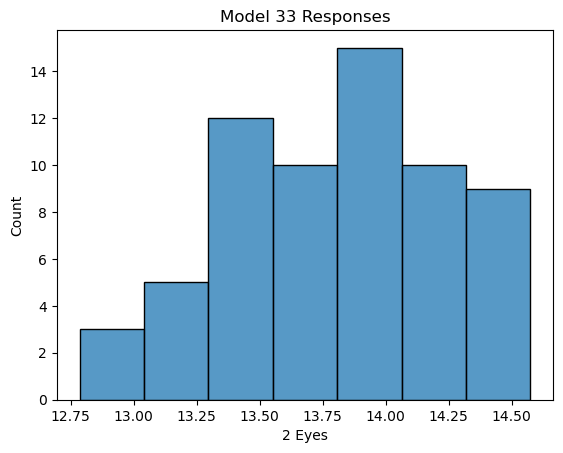

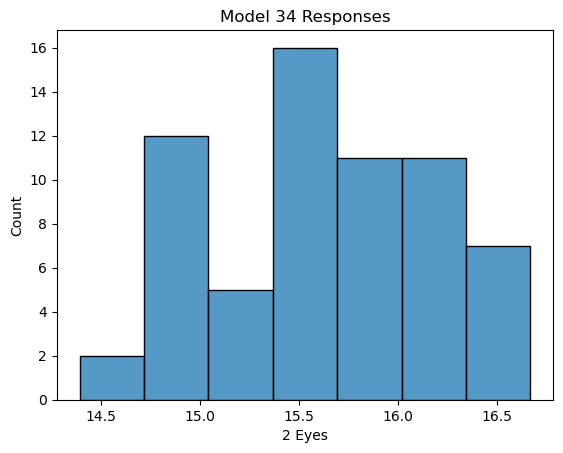

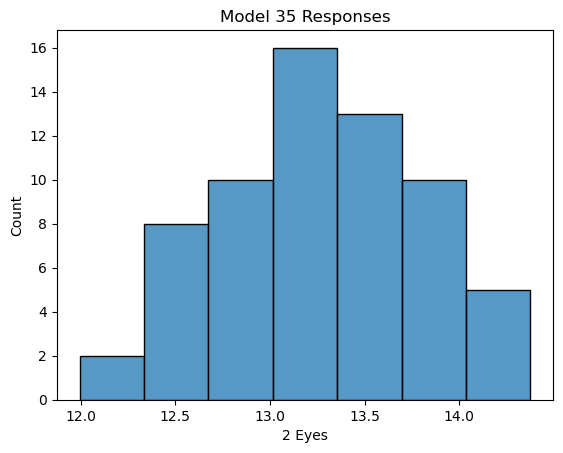

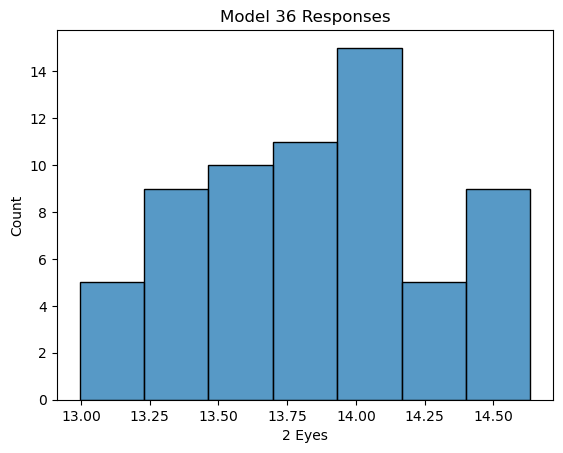

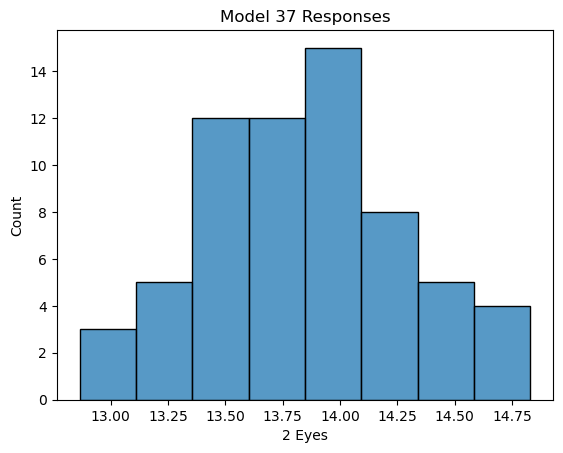

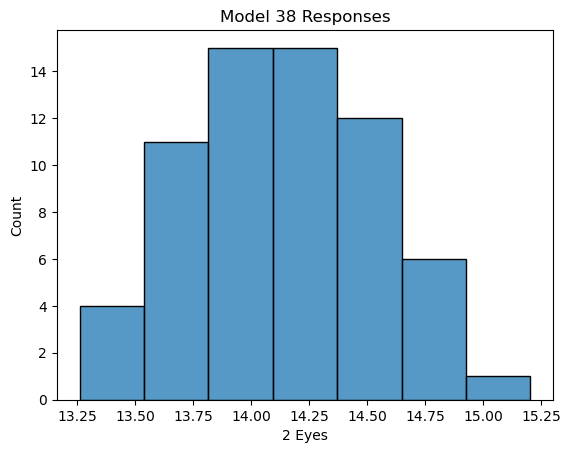

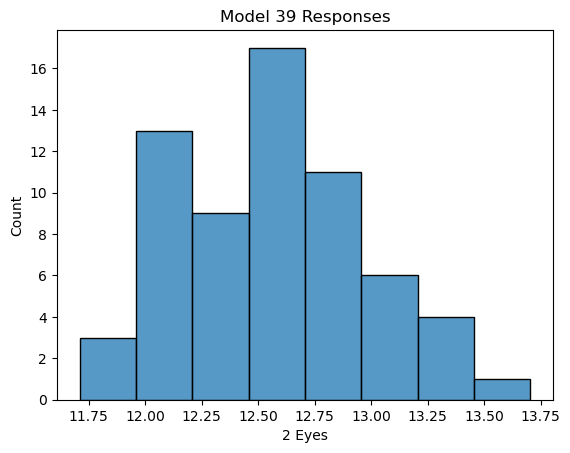

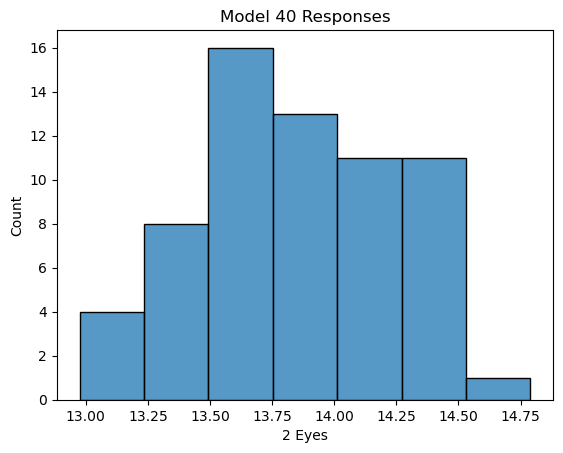

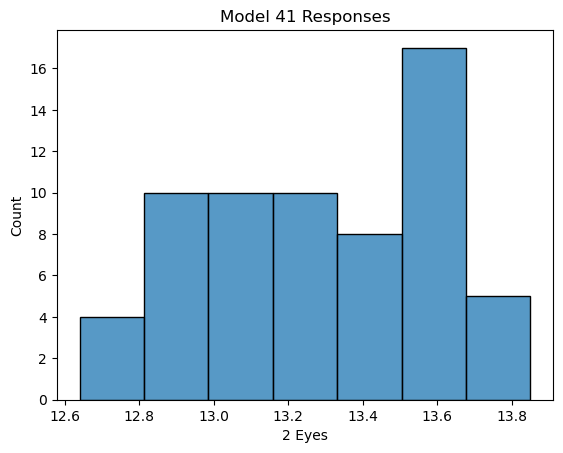

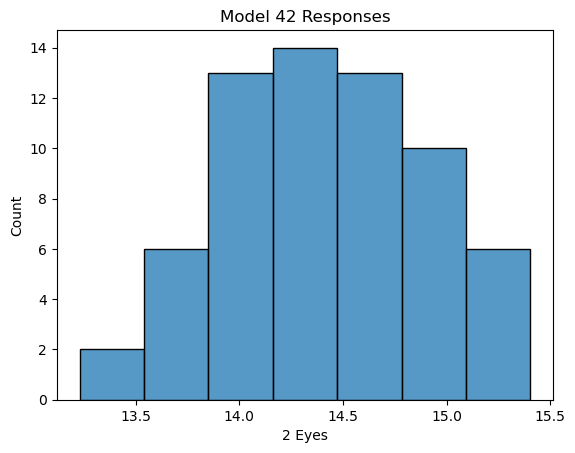

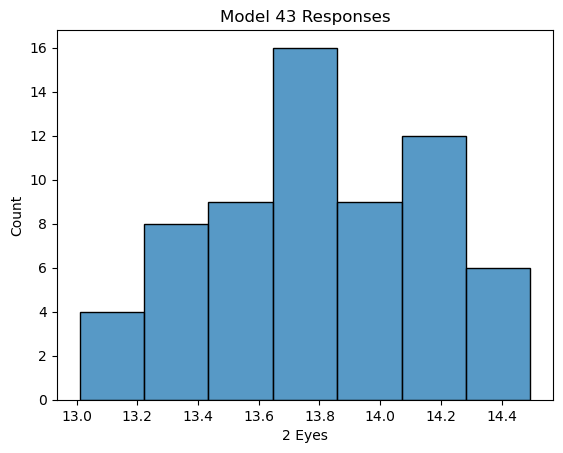

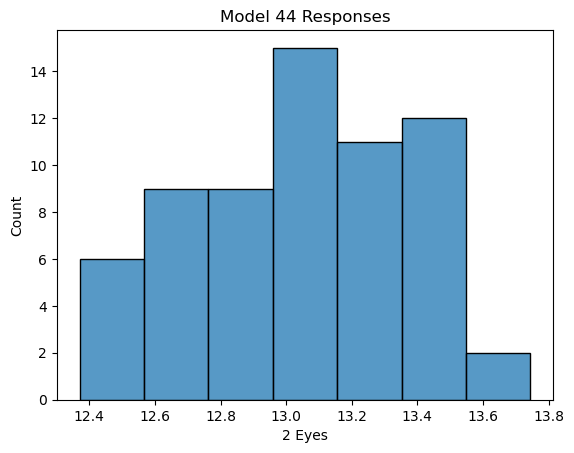

In [9]:
for i in range(population_size):
    series = extract_population_response(df_feature_combination, i, "2 Eyes")
    plt.figure()
    plt.title(f"Model {i} Responses")
    sns.histplot(series)
    plt.show()

# ANOVA

In [40]:
df_anova = pd.melt(df_mean_responses.reset_index(), id_vars=['model_idx'], value_vars=df_feature_combination.columns)
df_anova.columns = ["model_idx", "feature_combination", "mean"]
df_anova.head()

,model_idx,feature_combination,mean
0,0,1 Eye,14.647656
1,1,1 Eye,14.856719
2,2,1 Eye,15.385156
3,3,1 Eye,16.644141
4,4,1 Eye,15.116406


In [41]:
res = pg.rm_anova(data=df_anova, dv='mean', within='feature_combination', subject='model_idx', 
                  correction=True, detailed=True)
res

,Source,SS,DF,MS,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,feature_combination,493.423124,7,70.489018,882.324982,1.309630e-199,1.248915e-75,0.680993,0.37031,True,235828.505843,1.0
1,Error,24.606146,308,0.079890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Check Assumptions for ANOVA

In [42]:
pg.sphericity(data=df_anova, dv='mean', within='feature_combination', subject='model_idx')

SpherResults(spher=True, W=235828.50584308148, chi2=-512.8016076339339, dof=27, pval=1.0)

In [43]:
pg.normality(data=df_anova, dv='mean', group='feature_combination')

,W,pval,normal
feature_combination,,,
1 Eye,0.977328,0.515537,True
2 Eyes,0.960685,0.129727,True
"1 Eye, Nose",0.983788,0.773286,True
"1 Eye, Mouth",0.985699,0.845096,True
"2 Eyes, Nose",0.977629,0.526809,True
"1 Eye, Nose, Mouth",0.971648,0.331826,True
Full Face,0.973704,0.391551,True
"2 Eyes, Mouth",0.968916,0.264410,True


## Pairwise t-Tests

In [44]:
post_hocs = pg.pairwise_tests(data=df_anova, dv='mean', within='feature_combination', subject='model_idx', 
                              padjust='bonf', alternative='greater')
post_hocs[post_hocs.B=="Full Face"]
post_hocs

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,feature_combination,1 Eye,"1 Eye, Mouth",True,True,28.592758,44.0,greater,2.330382e-30,6.525070e-29,bonf,1.075e+27,1.898731
1,feature_combination,1 Eye,"1 Eye, Nose",True,True,23.972507,44.0,greater,3.433242e-27,9.613078e-26,bonf,8.795e+23,1.032709
2,feature_combination,1 Eye,"1 Eye, Nose, Mouth",True,True,34.604314,44.0,greater,7.475766e-34,2.093214e-32,bonf,2.748e+30,2.876643
3,feature_combination,1 Eye,2 Eyes,True,True,31.512738,44.0,greater,3.926943e-32,1.099544e-30,bonf,5.764e+28,1.934445
4,feature_combination,1 Eye,"2 Eyes, Mouth",True,True,40.115702,44.0,greater,1.363685e-36,3.818318e-35,bonf,1.294e+33,3.687751
5,feature_combination,1 Eye,"2 Eyes, Nose",True,True,37.719610,44.0,greater,1.901252e-35,5.323506e-34,bonf,9.884e+31,2.890793
6,feature_combination,1 Eye,Full Face,True,True,43.541683,44.0,greater,4.040177e-38,1.131250e-36,bonf,4.015e+34,4.524309
7,feature_combination,"1 Eye, Mouth","1 Eye, Nose",True,True,-12.295810,44.0,greater,1.000000e+00,1.000000e+00,bonf,6.173e-14,-0.876683
8,feature_combination,"1 Eye, Mouth","1 Eye, Nose, Mouth",True,True,24.974743,44.0,greater,6.389729e-28,1.789124e-26,bonf,4.524e+24,1.068259
9,feature_combination,"1 Eye, Mouth",2 Eyes,True,True,1.579777,44.0,greater,6.066044e-02,1.000000e+00,bonf,1.021,0.130711


# 1 Parafoveal Feature

In [15]:
results = pairwise_anova(df_anova, ["2 Eyes", "1 Eye, Nose", "1 Eye, Mouth"], 
                         dv='mean', within='feature_combination', subject='model_idx', 
                         correction=True, detailed=True)

In [16]:
for result in results:
    print(f"{result[0]} and {result[1]} gives")
    try:
        print("\t", result[2]["p-GG-corr"][0])
    except:
        print("\t", result[2]["p-unc"][0])

2 Eyes and 1 Eye, Nose gives
	 1.6824528023078283e-17
2 Eyes and 1 Eye, Mouth gives
	 0.12132088808344298
1 Eye, Nose and 1 Eye, Mouth gives
	 7.880424929880695e-16


# 2 Parafoveal Features

In [17]:
results = pairwise_anova(df_anova, ["2 Eyes, Nose", "1 Eye, Nose, Mouth", "2 Eyes, Mouth"], 
                         dv='mean', within='feature_combination', subject='model_idx', 
                         correction=True, detailed=True)

In [18]:
for result in results:
    print(f"{result[0]} and {result[1]} gives")
    try:
        print("\t", result[2]["p-GG-corr"][0])
    except:
        print("\t", result[2]["p-unc"][0])

2 Eyes, Nose and 1 Eye, Nose, Mouth gives
	 0.09015979874161752
2 Eyes, Nose and 2 Eyes, Mouth gives
	 4.414075089921053e-16
1 Eye, Nose, Mouth and 2 Eyes, Mouth gives
	 2.978597575883827e-18


# Parafoveal Feature Count

In [47]:
df_parafoveal = pd.DataFrame(0, index=np.arange(population_size), columns=["0 Parafoveal Features",
                                                                          "1 Parafoveal Features",
                                                                          "2 Parafoveal Features",
                                                                          "3 Parafoveal Features",
                                                                          "model_idx"])
for model_idx in range(population_size):
    df_parafoveal.at[model_idx, "0 Parafoveal Features"] = df_mean_responses["1 Eye"].iloc[model_idx]
    df_parafoveal.at[model_idx, "1 Parafoveal Features"] = df_mean_responses[["2 Eyes", "1 Eye, Nose", "1 Eye, Mouth"]].iloc[model_idx].mean()
    df_parafoveal.at[model_idx, "2 Parafoveal Features"] = df_mean_responses[["2 Eyes, Nose", "1 Eye, Nose, Mouth", "2 Eyes, Mouth"]].iloc[model_idx].mean()
    df_parafoveal.at[model_idx, "3 Parafoveal Features"] = df_mean_responses["Full Face"].iloc[model_idx]
    df_parafoveal.at[model_idx, "model_idx"] = model_idx

In [48]:
df_parafoveal.head()

,0 Parafoveal Features,1 Parafoveal Features,2 Parafoveal Features,3 Parafoveal Features,model_idx
0,14.647656,13.148906,11.924818,10.902188,0
1,14.856719,13.238698,11.929818,10.861406,1
2,15.385156,13.622630,12.204271,11.053281,2
3,16.644141,14.604948,13.009661,11.756484,3
4,15.116406,13.477396,12.163698,11.096719,4


## Anova

In [49]:
df_parafoveal_anova = pd.melt(df_parafoveal.reset_index(), id_vars=['model_idx'], value_vars=df_parafoveal.columns)
df_parafoveal_anova.columns = ["model_idx", "parafovea", "mean"]
df_parafoveal_anova.head()

,model_idx,parafovea,mean
0,0,0 Parafoveal Features,14.647656
1,1,0 Parafoveal Features,14.856719
2,2,0 Parafoveal Features,15.385156
3,3,0 Parafoveal Features,16.644141
4,4,0 Parafoveal Features,15.116406


In [50]:
res = pg.rm_anova(data=df_parafoveal_anova, dv='mean', within='parafovea', subject='model_idx', 
                  correction=True, detailed=True)
res

,Source,SS,DF,MS,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,parafovea,384.555076,3,128.185025,1872.920409,5.966549e-108,9.168803e-38,0.768949,0.333892,True,641.523164,1.0
1,Error,9.034246,132,0.068441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Check Assumptions

In [51]:
pg.sphericity(data=df_parafoveal_anova, dv='mean', within='parafovea', subject='model_idx')

SpherResults(spher=True, W=641.5231639539438, chi2=-276.14983499416655, dof=5, pval=1.0)

In [52]:
pg.normality(data=df_parafoveal_anova, dv='mean', group='parafovea')

,W,pval,normal
parafovea,,,
0 Parafoveal Features,0.977328,0.515537,True
1 Parafoveal Features,0.980311,0.632281,True
2 Parafoveal Features,0.980226,0.628839,True
3 Parafoveal Features,0.973704,0.391551,True


## Pairwise t-Tests

In [53]:
post_hocs = pg.pairwise_tests(data=df_parafoveal_anova, dv='mean', within='parafovea', subject='model_idx', 
                              padjust='bonf', alternative='greater')
post_hocs[post_hocs.B=="3 Parafoveal Features"]
post_hocs

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,parafovea,0 Parafoveal Features,1 Parafoveal Features,True,True,37.997128,44.0,greater,1.390093e-35,8.340557e-35,bonf,1.342e+32,1.643028
1,parafovea,0 Parafoveal Features,2 Parafoveal Features,True,True,40.867112,44.0,greater,6.154065e-37,3.692439e-36,bonf,2.812e+33,3.187298
2,parafovea,0 Parafoveal Features,3 Parafoveal Features,True,True,43.541683,44.0,greater,4.040177e-38,2.424106e-37,bonf,4.015e+34,4.524309
3,parafovea,1 Parafoveal Features,2 Parafoveal Features,True,True,44.926290,44.0,greater,1.049738e-38,6.298427e-38,bonf,1.496e+35,1.678207
4,parafovea,1 Parafoveal Features,3 Parafoveal Features,True,True,48.147005,44.0,greater,5.295161e-40,3.177097e-39,bonf,2.764e+36,3.209641
5,parafovea,2 Parafoveal Features,3 Parafoveal Features,True,True,52.701703,44.0,greater,1.060427e-41,6.362561e-41,bonf,1.259e+38,1.621682


## Pairwise ANOVA

In [30]:
results = pairwise_anova(df_parafoveal_anova, ['0 Parafoveal Features', '1 Parafoveal Features',
                         '2 Parafoveal Features', '3 Parafoveal Features'], 
                         dv='mean', within='parafovea', subject='model_idx', 
                         correction=True, detailed=True)

In [31]:
for result in results:
    print(f"{result[0]} and {result[1]} gives")
    try:
        print("\t", result[2]["p-GG-corr"][0])
    except:
        print("\t", result[2]["p-unc"][0])

0 Parafoveal Features and 1 Parafoveal Features gives
	 2.7801855065988087e-35
0 Parafoveal Features and 2 Parafoveal Features gives
	 1.2308130088991985e-36
0 Parafoveal Features and 3 Parafoveal Features gives
	 8.080354742292325e-38
1 Parafoveal Features and 2 Parafoveal Features gives
	 2.0994755414423397e-38
1 Parafoveal Features and 3 Parafoveal Features gives
	 1.0590322258848192e-39
2 Parafoveal Features and 3 Parafoveal Features gives
	 2.1208538143108464e-41
